<a href="https://colab.research.google.com/github/alanfmorato/Churn/blob/main/Desafio_de_Classifica%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gabarito - Desafio de Classificação
## Preveja os usuários com alta chance de deixar seu Streaming
### Overview
Você trabalha em uma plataforma de streaming e a diretoria está preocupada com o alto índice de usuários cancelando as suas assinaturas. Eles acreditam que é possível prever se um usuário tem mais chance de deixar a plataforma antes que isso aconteça, e com base nessa informação tomar ações para reduzir o churn.

Seu objetivo é criar um modelo de classificação capaz de prever se um usuário tem mais chance de cancelar a sua assinatura na plataforma ou não. Para isso, a empresa forneceu uma base de dados em csv contendo dados sobre as contas dos clientes.


### Sobre os dados


Fonte: [DNC](https://drive.google.com/file/d/1Z3z_Inr7WYZKYs5zeW2zi7_1-HNt8jBH/view?usp=sharing)


| Coluna | Descrição | Tipo |
| --- | --- | --- |
| Age | Idade do cliente | Int
| Gender | Gênero do cliente | String
| Time_on_platform | Tempo de uso da plataforma, em horas | Int
| Devices_connected | Quantidade de dispositivos conectados | Int
| Subscription_type | Tipo de conta | String
| Num_streaming_services | Quantidade de serviços de streaming que o cliente possui | Int
| Num_active_profiles | Número de perfis ativos na plataforma | Int
| Avg_rating | Avaliação média dos produtos da plataforma | Float
| Churned | Se o cliente cancelou a conta ou não | Boolean

### Importar bibliotecas necessárias

In [ ]:
!pip install feature-engine
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# análise de dados
import pandas as pd
import numpy as np

# visualização 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# divisão da base de dados
from sklearn.model_selection import train_test_split

# tratamento dos dados categóricos e numéricos
from sklearn.preprocessing import MinMaxScaler

# classificadores
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

# métricas de avaliação de qualidade
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, ConfusionMatrixDisplay

# remoção de aviso de erro para o BayesSearchCV
import warnings
warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')

# Acessar o drive
#from google.colab import drive
#drive.mount('/content/drive/')
#%cd /content/drive/My Drive/Colab Notebooks/

## Data Understanding

### Importar base de dados

In [ ]:
#Lendo os Dados
clients= pd.read_csv('/content/streaming_data.csv')
clients.head()

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49.0,Male,4700.0,3.0,Basic,NaN,3,NaN,0.0,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69.0,Female,6107.0,2.0,Standard,NaN,1,2.14,0.0,fe14b048-770b-4619-8ec6-485b0969ae31
2,44.0,Male,6374.0,3.0,Premium,1.0,1,1.91,1.0,0283dffd-6684-4a05-9c6f-c02098a6849d
3,26.0,Male,NaN,5.0,Basic,NaN,2,NaN,NaN,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
4,18.0,NaN,1948.0,3.0,Basic,NaN,3,3.88,0.0,14879bcb-1977-4ad8-a7f9-6aa9bf7b872f


##Data Preparation

### Tratar Valores Faltantes



In [ ]:
#Estatísticas Descritivas de todas as colunas

clients.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,66607.0,NaN,NaN,NaN,43.511072,15.043158,18.0,30.0,43.0,57.0,69.0
Gender,63368,2,Male,31796,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Time_on_platform,56464.0,NaN,NaN,NaN,4385.848505,2526.580859,0.0,2196.0,4384.0,6573.0,8759.0
Devices_connected,52696.0,NaN,NaN,NaN,2.99537,1.414072,1.0,2.0,3.0,4.0,5.0
Subscription_type,52663,3,Premium,17625,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Num_streaming_services,9572.0,NaN,NaN,NaN,2.496239,1.1207,1.0,1.0,2.0,4.0,4.0
Num_active_profiles,77884.0,NaN,NaN,NaN,3.002273,1.413235,1.0,2.0,3.0,4.0,5.0
Avg_rating,60614.0,NaN,NaN,NaN,3.002252,1.154963,1.0,1.99,3.01,4.0,5.0
Churned,61148.0,NaN,NaN,NaN,0.243066,0.428938,0.0,0.0,0.0,0.0,1.0
User_id,77884,65481,9c66e5a1-0541-4496-8fbc-ee425ee08b78,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Verificando os tipos de dados
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77884 entries, 0 to 77883
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     66607 non-null  float64
 1   Gender                  63368 non-null  object 
 2   Time_on_platform        56464 non-null  float64
 3   Devices_connected       52696 non-null  float64
 4   Subscription_type       52663 non-null  object 
 5   Num_streaming_services  9572 non-null   float64
 6   Num_active_profiles     77884 non-null  int64  
 7   Avg_rating              60614 non-null  float64
 8   Churned                 61148 non-null  float64
 9   User_id                 77884 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 5.9+ MB


In [ ]:
#Verificando a Quantidade de Nulos
clients.isna().sum()

Age                       11277
Gender                    14516
Time_on_platform          21420
Devices_connected         25188
Subscription_type         25221
Num_streaming_services    68312
Num_active_profiles           0
Avg_rating                17270
Churned                   16736
User_id                       0
dtype: int64

In [ ]:
#Tratando os valores faltantes
clients['Age'] = clients['Age'].fillna(0)
clients['Time_on_platform'] = clients['Time_on_platform'].fillna(0)
clients['Num_streaming_services'] = clients['Num_streaming_services'].fillna(0)
clients['Churned'] = clients['Churned'].fillna(0)
clients['Avg_rating'] = clients['Avg_rating'].fillna(0)


In [ ]:
clients.dropna(subset=['Gender'], inplace=True)

In [ ]:
clients.dropna(subset=['Subscription_type'], inplace=True)

In [ ]:
clients.isna().sum()

Age                           0
Gender                        0
Time_on_platform              0
Devices_connected         13695
Subscription_type             0
Num_streaming_services        0
Num_active_profiles           0
Avg_rating                    0
Churned                       0
User_id                       0
dtype: int64

In [ ]:
clients.query("User_id == 'NaN'")

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id


In [ ]:
clients['Churned'] = clients['Churned'].replace(0, 'No')

In [ ]:
clients['Churned'] = clients['Churned'].replace(1, 'Yes')

In [ ]:
clients.head()

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49.0,Male,4700.0,3.0,Basic,0.0,3,0.00,No,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69.0,Female,6107.0,2.0,Standard,0.0,1,2.14,No,fe14b048-770b-4619-8ec6-485b0969ae31
2,44.0,Male,6374.0,3.0,Premium,1.0,1,1.91,Yes,0283dffd-6684-4a05-9c6f-c02098a6849d
3,26.0,Male,0.0,5.0,Basic,0.0,2,0.00,No,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
5,54.0,Male,3024.0,2.0,Basic,0.0,1,0.00,No,a1df3a13-9255-4d00-8a9d-20565fefaab9


In [ ]:
clients.shape

(42795, 10)

###Tratar tipos de dados

In [ ]:
#Transformando valores floats em valores inteiros
clients['Age'] = clients['Age'].astype(int)
clients['Time_on_platform'] = clients['Time_on_platform'].astype(int)
clients['Num_streaming_services'] = clients['Num_streaming_services'].astype(int)

###Outliers

In [ ]:
clients.head()

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49,Male,4700,3.0,Basic,0,3,0.00,No,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69,Female,6107,2.0,Standard,0,1,2.14,No,fe14b048-770b-4619-8ec6-485b0969ae31
2,44,Male,6374,3.0,Premium,1,1,1.91,Yes,0283dffd-6684-4a05-9c6f-c02098a6849d
3,26,Male,0,5.0,Basic,0,2,0.00,No,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
5,54,Male,3024,2.0,Basic,0,1,0.00,No,a1df3a13-9255-4d00-8a9d-20565fefaab9


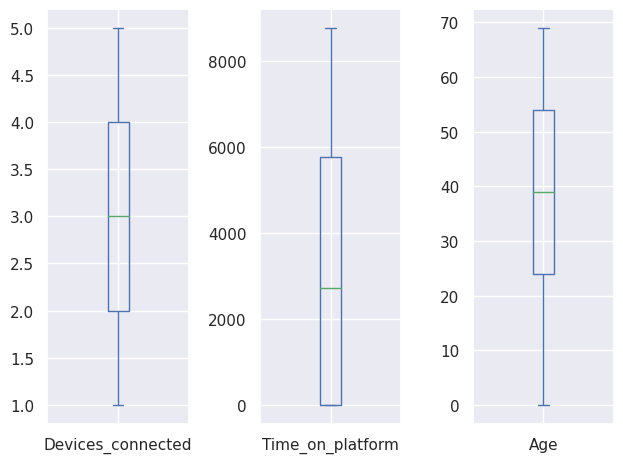

In [ ]:
#Verificando outliers
clients[['Devices_connected', 'Time_on_platform', 'Age']].plot(kind='box', subplots=True)
plt.tight_layout()
plt.show()

###Análise Exploratória

In [ ]:
sns.set_palette("Accent")
sns.set_style("darkgrid")

In [ ]:
#Agrupando Clientes que deram churn por userid
Churn_UserId = clients.groupby("Churned")['User_id'].count().reset_index()

<Axes: xlabel='Churned', ylabel='User_id'>

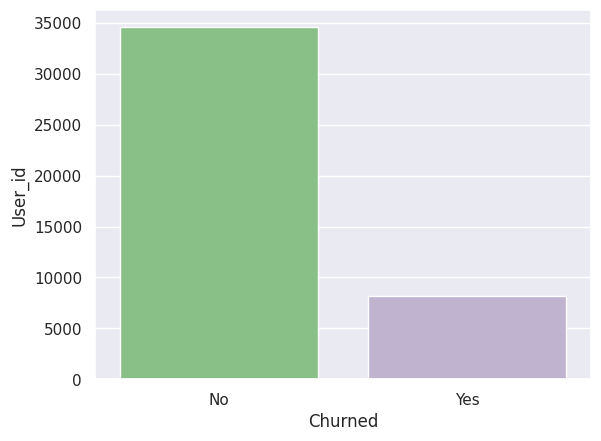

In [ ]:
#Plotando quantidade de clientes que deram churn (1) e que não deram churn (0)
sns.barplot(data=Churn_UserId, x = "Churned",y = "User_id")

In [ ]:
#Agrupando quantidade de clientes por plano
Churn_Subscription = clients.groupby("Subscription_type")['User_id'].count().reset_index()
Churn_Subscription = pd.DataFrame(Churn_Subscription)
Churn_Subscription

,Subscription_type,User_id
0,Basic,14219
1,Premium,14261
2,Standard,14315


<Axes: xlabel='User_id', ylabel='Subscription_type'>

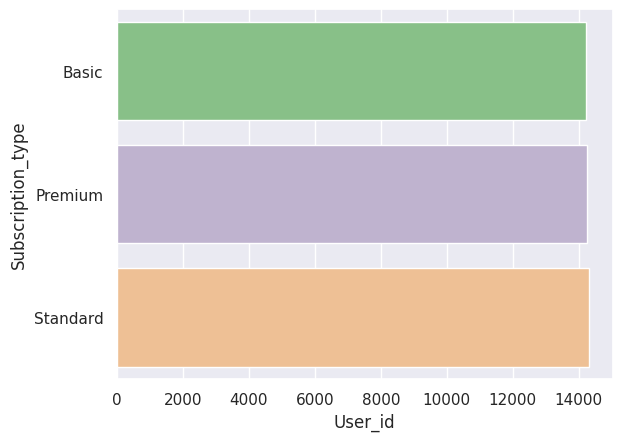

In [ ]:
#Plotando quantidade de clientes por plano
sns.barplot(data=Churn_Subscription, x = "User_id",y = "Subscription_type")

In [ ]:
#Agrupando quantidade de clientes por genero
Churn_gender = clients.groupby("Gender")['User_id'].count().reset_index()
Churn_gender = pd.DataFrame(Churn_gender)
Churn_gender

,Gender,User_id
0,Female,21187
1,Male,21608


<Axes: xlabel='User_id', ylabel='Gender'>

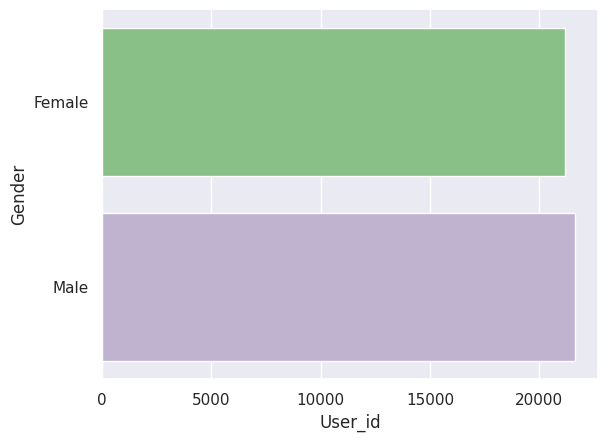

In [ ]:
#Plotando quantidade de clientes por genero
sns.barplot(data=Churn_gender, x = "User_id",y = "Gender")

##Modeling

In [ ]:
clients.head()

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49,Male,4700,3.0,Basic,0,3,0.00,No,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69,Female,6107,2.0,Standard,0,1,2.14,No,fe14b048-770b-4619-8ec6-485b0969ae31
2,44,Male,6374,3.0,Premium,1,1,1.91,Yes,0283dffd-6684-4a05-9c6f-c02098a6849d
3,26,Male,0,5.0,Basic,0,2,0.00,No,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
5,54,Male,3024,2.0,Basic,0,1,0.00,No,a1df3a13-9255-4d00-8a9d-20565fefaab9


In [ ]:
#Definindo variáveis
X = clients.drop(columns=['User_id', 'Churned'], axis = 1)

In [ ]:
X

,0,1,2,3,4,5,6,7,8,9,10
0,0.710145,0.536591,0.50,0.00,0.50,0.000,0.0,1.0,1.0,0.0,0.0
1,1.000000,0.697226,0.25,0.00,0.00,0.428,1.0,0.0,0.0,0.0,1.0
2,0.637681,0.727709,0.50,0.25,0.00,0.382,0.0,1.0,0.0,1.0,0.0
3,0.376812,0.000000,1.00,0.00,0.25,0.000,0.0,1.0,1.0,0.0,0.0
4,0.782609,0.345245,0.25,0.00,0.00,0.000,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
42790,0.652174,0.000000,NaN,0.00,1.00,0.440,0.0,1.0,1.0,0.0,0.0
42791,0.681159,0.705103,NaN,0.00,0.25,0.908,1.0,0.0,0.0,1.0,0.0
42792,0.927536,0.000000,1.00,0.00,0.00,0.868,1.0,0.0,0.0,1.0,0.0
42793,0.840580,0.150017,1.00,0.00,0.75,0.000,0.0,1.0,0.0,0.0,1.0


In [ ]:
#Definindo variáveis

y = clients[['Churned']]

In [ ]:
#Fitando modelo
le = LabelEncoder()
le.fit(y.Churned)
y.Churned = le.transform(y.Churned)

<ipython-input-166-797273e92d7d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.Churned = le.transform(y.Churned)


In [ ]:
X = pd.get_dummies(X)

In [ ]:
#Feature engineering
mm = MinMaxScaler()

X = pd.DataFrame(mm.fit_transform(X))

In [ ]:
#Separando a base de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [ ]:
model = LogisticRegression()

In [ ]:
lr = model.fit(X_train, y_train)

ValueError: ignored

- Divisão dos dados em categóricos e numéricos

In [ ]:
num = ['Age', 'Time_on_platform', 'Devices_connected', 'Num_streaming_services', 'Num_active_profiles', 'Avg_rating']
cat = ['Gender', 'Subscription_type']
target = ['Churned']

- Visualização dos dados

### Pré-processamento

### Algoritmos de classificação

### Interpretabilidade do modelo